# Телекоммуникации
## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

## План проекта

1. Ознакомиться с данными, провести исследовательский анализ

2. Обучить модели

3. Анализ моделей

4. Подвести итоги, сделать выводы, дать рекоммендации.

Выполним импорт библиотек

In [ ]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# импортируем нужные нам библиотеки
import pandas as pd
import time
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import  RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score
)

# загружаем нужные классы
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# класс для работы с пропусками
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
# отключаем предупреждения
import warnings
warnings.filterwarnings("ignore")
import re
from sklearn.pipeline import make_pipeline

Константы

In [ ]:
TEST_SIZE=0.25
RANDOM_STATE = 91224

Функции

In [ ]:
# функция, чтобы узнать информацию о данных
def df_info(df):
    # размер датасета
    print('Размер датафрейма:',df.shape)
    # посмотрим первые 5 строк данных
    print('Первые 5 строк:')
    display(df.head())
    print('Последние 5 строк:')
    display(df.tail())
    # тип данных
    print('Описательные статистики:')
    display(df.describe())
    print('Типы данных')
    display(df.info())

In [ ]:
# функция для построения гистограммы и ящика с усами

def hist_box(data,col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    #гистограмма
    sns.histplot(data = data, x = col, ax=axes[0], bins=50,kde=True)
    axes[0].set_title('гистограмма')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('колво')
    #ящик с усами
    sns.boxplot(data = data, x=col, ax=axes[1])
    axes[1].set_title('диаграмма размаха')
    fig.suptitle(col)
    plt.show()

In [ ]:
# функция для построения графика для категориальных данных
def graf(data,col,label):
    print(data[col].value_counts())
    data[col].groupby(data[col]).count().plot(kind="pie",ylabel=label);

## Загрузка данных

In [ ]:
#читаем данные
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
    print('load from current website')
except:
    print('error')


load from current website


**contract**

In [ ]:
df_info(contract)

Размер датафрейма: (7043, 8)
Первые 5 строк:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Последние 5 строк:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82


Описательные статистики:


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Датасет с информацией о договоре имеет 8 столбцов и 7043 строк. стоит скорректировать тип данных у столбца TotalCharges ( общие расходы абонента), приведя к float64 и даты приведем к datetime. Сделаем это в шаге предобработки.
Также в предобработке проверим дату начала - Информация о договорах актуальна на 1 февраля 2020 года. значит дата начала не может быть больше.

**personal**

In [ ]:
df_info(personal)

Размер датафрейма: (7043, 5)
Первые 5 строк:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Последние 5 строк:


,customerID,gender,SeniorCitizen,Partner,Dependents
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No
7042,3186-AJIEK,Male,0,No,No


Описательные статистики:


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Данные содержат инфо о персональных данных клиента и состоит из 5 столбцов и 7043 строк. Типы данных соответствуют.

**internet**

In [ ]:
df_info(internet)

Размер датафрейма: (5517, 8)
Первые 5 строк:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Последние 5 строк:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No
5516,3186-AJIEK,Fiber optic,Yes,No,Yes,Yes,Yes,Yes


Описательные статистики:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2091-GPPIQ,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Датасет internet содержит информацию об интернет-услугах. 8 столбцов.Типы данных соответствуют.

**phone**

In [ ]:
df_info(phone)

Размер датафрейма: (6361, 2)
Первые 5 строк:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Последние 5 строк:


,customerID,MultipleLines
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes
6360,3186-AJIEK,No


Описательные статистики:


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,4486-EFAEB,No
freq,1,3390


Типы данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Датасет phone содержит информацию об услугах телефонии. 2 столбца.Типы данных соответствуют.

Проверим дубликаты в датасетах:

In [ ]:
l = [contract, personal, internet, phone]
for i in l:
     print( 'Количество дублей в датасете:', i.duplicated().sum())

Количество дублей в датасете: 0
Количество дублей в датасете: 0
Количество дублей в датасете: 0
Количество дублей в датасете: 0


**Вывод**:

Мы прочитали данные, посмотрели на 5 первых и последних строк в датасетах. Получили описательные статистики.

   Пропусков нет, типы данных соответствуют.

## Исследовательский анализ и предобработка данных
### contract

**contract**
проверим значения некоторых столбцов.

BeginDate не должно быть из будущего, проверим что дата не больше, чем 1.02.2020

In [ ]:
# приведем к типу datetime
contract['BeginDate']= pd.to_datetime(contract['BeginDate'])
contract['BeginDate'].describe()

count                    7043
unique                     77
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-02-01 00:00:00
Name: BeginDate, dtype: object

мы изменили тип данных на datetime. Диапазон в порядке. Самый первый договор был открыт 1 октября 2013,  а последний 1 февраля 2020.

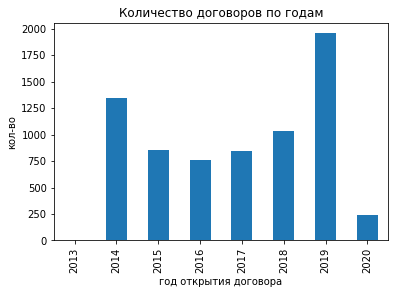

In [ ]:
contract['BeginDate'].groupby(contract['BeginDate'].dt.year).count().plot(kind="bar",ylabel='кол-во', xlabel='год открытия договора', title='Количество договоров по годам');

C 2014 идет спад, возможно, появились конкуренты с более интересными условиями, с 2016 снова рост. вероятно, компания зарекомендовала  себя как надежный поставщик (уже долго на рынке) качественных услуг.

In [ ]:
#проверим значения  дата окончания действия договора;
contract['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

Из данного столбца будет лучше создать 2 признака:

    1) активность контракта (0 если дата есть, 1 если стоит 'No'),
    
    2) продолжительнсть в днях

In [ ]:
# Создание признака "active_contract"
contract['is_active'] = 1
contract.loc[contract['EndDate'] == 'No', 'is_active'] = 0

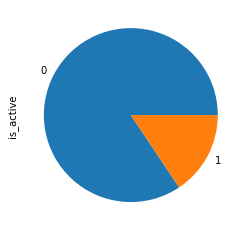

In [ ]:
contract['Type'].groupby(contract['is_active']).count().plot(kind="pie",ylabel='is_active');

In [ ]:
# заменим в "EndDate"  no на дату сбора данных
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
contract['EndDate'] = pd.to_datetime(
    contract['EndDate']
)

# посчитаем продолжительность контракта в днях. назовем duration
contract['duration'] = (contract['EndDate'] - contract['BeginDate']).dt.components.days

In [ ]:
#проверим категориальные значения тип оплаты
contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

значения корректны, опечаток нет.

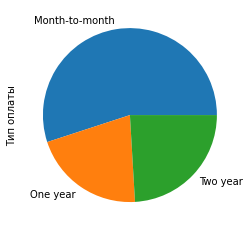

In [ ]:
contract['Type'].groupby(contract['Type']).count().plot(kind="pie",ylabel='Тип оплаты');

Более половины пользователей предпочитают ежемесячную оплату. На втором месте раз в два года. Реже всего раз в год.

Мое предположение, что оплату раз в два года более предпочтительна бизнесу и компаниям, а не физлицам.

In [ ]:
# проверим значения тип платежа
contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

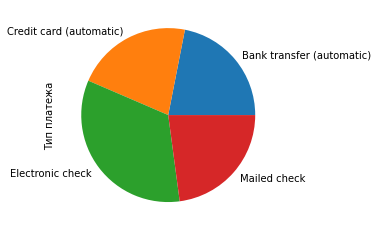

In [ ]:
contract['PaymentMethod'].groupby(contract['PaymentMethod']).count().plot(kind="pie",ylabel='Тип платежа');

имеется 4 вида платежа. самый востребованнйый - электронный чек.

In [ ]:
# проверим значения  электронный расчётный лист;
contract['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

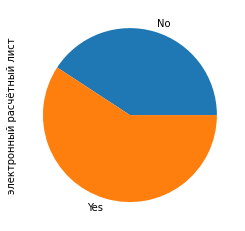

In [ ]:
contract['PaperlessBilling'].groupby(contract['PaperlessBilling']).count().plot(kind="pie",ylabel='электронный расчётный лист');

большинство преподчитают работать с электронным расчетным листом

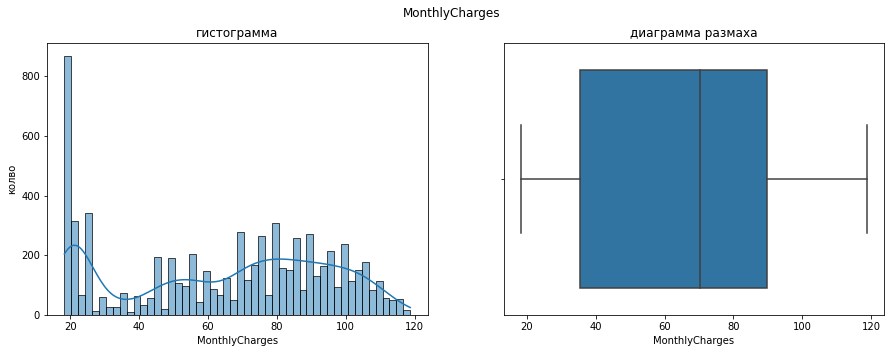

In [ ]:
hist_box(contract,'MonthlyCharges')

Распределение без выбросов и аномалий,чаще всего расходы за месяц не превышают 20 д.е.

Прежде чем заменить пропуски в TotalCharges, проверю данные с этим условием  (TotalCharges = пусто).

In [ ]:
contract.loc[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,is_active,duration
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0,0


Видим, что пропуски образуют клиенты, заключившие договор в дату сбора данных - 1 февраля 2020. Вероятно, они еще не оплачивали услуги, поэтому заменяю пропуски в  тратах на 0.

In [ ]:
# заменим пропуски на 0, изменим тип данных
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = 0
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')

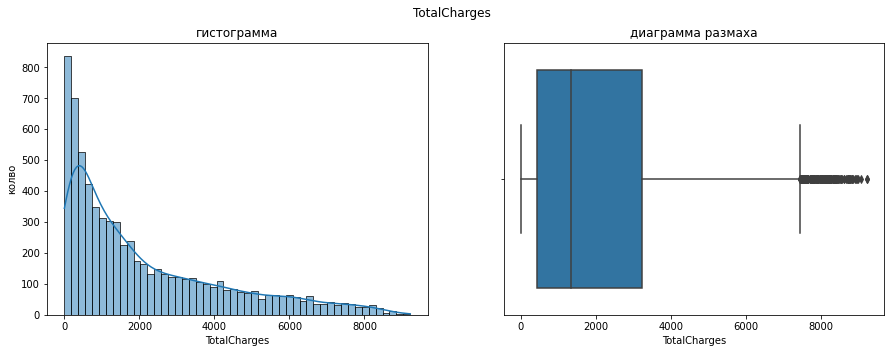

In [ ]:
hist_box(contract,'TotalCharges')

Распределение нормальное, скошено вправо, выбросов много.

In [ ]:
#  приведем к змеиному регистру
contract.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in contract.columns]
contract = contract.rename(columns={'customer_i_d':'customer_id'})

#проверим
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'is_active',
       'duration'],
      dtype='object')

In [ ]:
contract = contract.drop(['begin_date', 'end_date'], axis=1)

**Вывод по датасету contract**

я переименовала столбцы в соответствие с змеиным регистром,

изменила тип данных у столбцов с датами на  datetime,

изменила тип у столбца total_charges со строкового признака на float64

также были созданы новые признаки - признак активности контракта и продолжительность контракта.

дату начала и дата завершения  удаляю. так как будем работать с новыми признаками.



### personal

In [ ]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

значения корректны

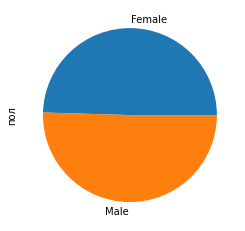

In [ ]:
personal['gender'].groupby(personal['gender']).count().plot(kind="pie",ylabel='пол');

мужчин чуть больше, чем женщин

In [ ]:
personal['SeniorCitizen'].value_counts()


0    5901
1    1142
Name: SeniorCitizen, dtype: int64

значения корректны, но эти бинарные значение отличаются от последующих, приведем к единому виду и заменим 0 на  'No', и 1на  'Yes'

In [ ]:
#personal['SeniorCitizen'].replace({0: 'No', 1: 'Yes'}, inplace=True)
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('object')

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
    
привела к строковому типу, ручная кодировка удалена

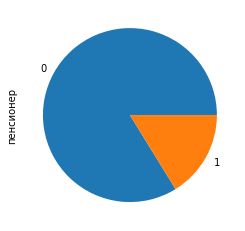

In [ ]:
personal['SeniorCitizen'].groupby(personal['SeniorCitizen']).count().plot(kind="pie",ylabel='пенсионер');

Большинство клиентов не являются пенсионерами.

In [ ]:
personal['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

значения корректны

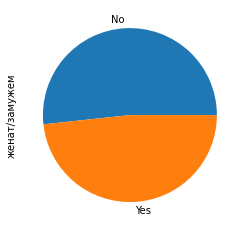

In [ ]:
personal['Partner'].groupby(personal['Partner']).count().plot(kind="pie",ylabel='женат/замужем');

Большинство клиентов холосты

In [ ]:
personal['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

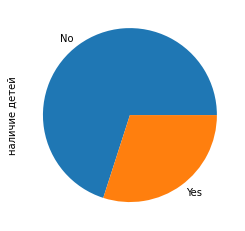

In [ ]:
personal['Dependents'].groupby(personal['Dependents']).count().plot(kind="pie",ylabel='наличие детей');

бОльшая часть клиентов без детей.

In [ ]:
#  приведем к змеиному регистру
personal.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in personal.columns]
personal = personal.rename(columns={'customer_i_d':'customer_id'})

#проверим
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

**Вывод по personal**

В датасете 5 столбцов, customerID и 4 бинарных категориальных признака.

Значения корректны, названия столбцов заменены в стиле змеиного регистра.


### internet

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64


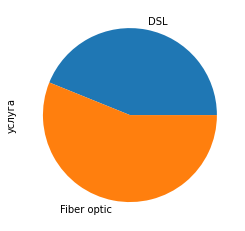

In [ ]:
graf(internet,'InternetService','услуга')

Значения корректны, большинство клиентов с типом подключения = оптоволоконный кабель

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64


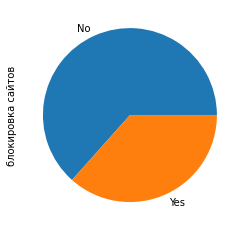

In [ ]:
graf(internet,'OnlineSecurity','блокировка сайтов')

Большинство клиентов предпочитают не подключать  блокировка опасных сайтов

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64


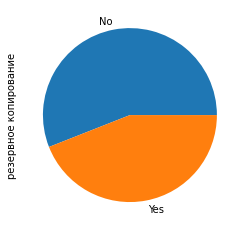

In [ ]:
graf(internet,'OnlineBackup','резервное копирование')

Большинство клиентов предпочитают не подключать  облачное хранилище файлов для резервного копирования данных;

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64


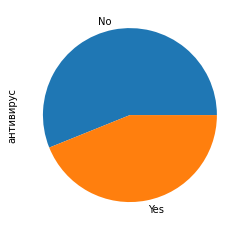

In [ ]:
graf(internet,'DeviceProtection','антивирус')

Большинство клиентов предпочитают не подключать антивирус

No     3473
Yes    2044
Name: TechSupport, dtype: int64


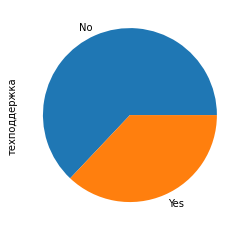

In [ ]:
graf(internet,'TechSupport','техподдержка')

Большинство клиентов предпочитают не подключать услугу техподдержка

No     2810
Yes    2707
Name: StreamingTV, dtype: int64


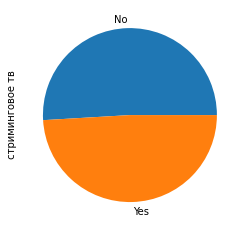

In [ ]:
graf(internet,'StreamingTV',' стриминговое тв')

Почти половина клиентов  подключили услугу стриминговое телевидение;

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64


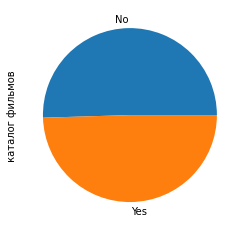

In [ ]:
graf(internet,'StreamingMovies',' каталог фильмов ')

Почти половина клиентов  подключили каталог фильмов

In [ ]:
#  приведем к змеиному регистру
# ставим нижнее подчеркивание перед заглавной буквой, переводим в нижний регистр
internet.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in internet.columns]
# поправим наименование для столбца с клиент ид
internet = internet.rename(columns={'customer_i_d':'customer_id','streaming_t_v':'streaming_tv'})

#проверим
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

**вывод по internet**

### phone

No     3390
Yes    2971
Name: MultipleLines, dtype: int64


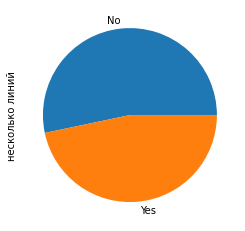

In [ ]:
graf(phone,'MultipleLines','несколько линий')

In [ ]:
# приведем к змеиному регистру
phone = phone.rename(columns={'customerID':'customer_id','MultipleLines':'multiple_lines'})
phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

**вывод по phone**

в датасете всего 2 столбца - ид клиента и бинарный признак наличия подключение телефона к нескольким линиям одновременно.

наименования этих столбцов были переведены в змеиный регистр.

## Объединение данных
В каждой табличке есть идентификатор клиента, объединять будем по нему(customer_id)

In [ ]:
df = personal.merge(contract, on ='customer_id', how='inner')
df = df.merge(internet, on ='customer_id', how = 'outer')
df = df.merge(phone, on ='customer_id', how = 'outer')


In [ ]:
df_info(df)

Размер датафрейма: (7043, 20)
Первые 5 строк:


,customer_id,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,is_active,duration,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,2071.84,0,1036,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Fiber optic,No,No,No,No,No,No,No


Последние 5 строк:


,customer_id,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,is_active,duration,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
7038,6840-RESVB,Male,0,Yes,Yes,One year,Yes,Mailed check,84.80,2035.20,0,730,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7430.40,0,2191,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes,Month-to-month,Yes,Electronic check,29.60,325.60,0,337,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,Male,1,Yes,No,Month-to-month,Yes,Mailed check,74.40,520.80,0,215,Fiber optic,No,No,No,No,No,No,Yes
7042,3186-AJIEK,Male,0,No,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82,0,2010,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No


Описательные статистики:


,monthly_charges,total_charges,is_active,duration
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.156325,898.555729
std,30.090047,2112.742814,0.363189,683.130510
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,276.000000
50%,70.350000,1343.350000,0.000000,761.000000
75%,89.850000,3236.690000,0.000000,1461.000000
max,118.750000,9221.380000,1.000000,2314.000000


Типы данных
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   object 
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   type               7043 non-null   object 
 6   paperless_billing  7043 non-null   object 
 7   payment_method     7043 non-null   object 
 8   monthly_charges    7043 non-null   float64
 9   total_charges      7043 non-null   float64
 10  is_active          7043 non-null   int64  
 11  duration           7043 non-null   int64  
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support

None

In [ ]:
# Проверим дубли
df.duplicated().sum()

0

In [ ]:
df.isna().sum()

customer_id             0
gender                  0
senior_citizen          0
partner                 0
dependents              0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
is_active               0
duration                0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

большая часть пропусков в столбцах, где говорится о подключении какой-либо услуги.
пропуск говорит об отсутствии пакета услуг. Заменю такие пропуски на 'without'

In [ ]:
df = df.fillna('without')
df.isna().sum()

customer_id          0
gender               0
senior_citizen       0
partner              0
dependents           0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
is_active            0
duration             0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

In [ ]:
df.shape

(7043, 20)

Вывод
    получился большой датафрейм из 4-х, в нем 7043 строк и 22 столбца.
    
    пропуски в значениях я заменила на unk
    
    дублей нет
    

## Исследовательский анализ и предобработка данных объединённого датафрейма

In [ ]:
#выделим ушедших клиентов в отдельный дф с помощью query
segment_0 = df.query('is_active==0')


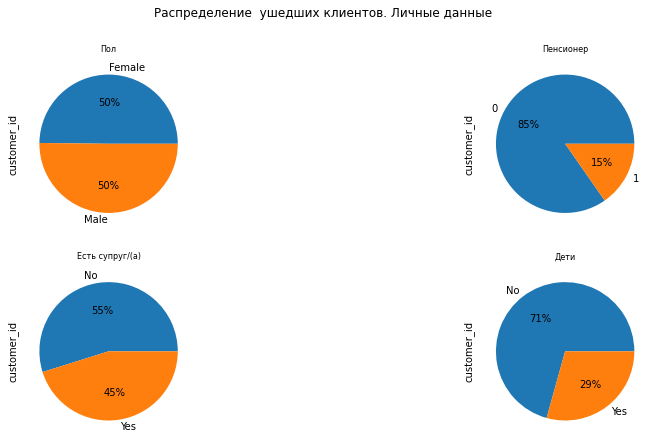

In [ ]:
# построим диаграмму для составления портрета ушедшего клиента. начнем с личных данных
plt.figure(figsize=[15, 7])
plt.suptitle('Распределение  ушедших клиентов. Личные данные')
plt.subplot(2,2,1)
segment_0.groupby(['gender'])['customer_id'].count().plot(kind = 'pie', autopct='%1.0f%%')
plt.title('Пол', fontsize= 8 )
plt.subplot(2,2,2)
segment_0.groupby(['senior_citizen'])['customer_id'].count().plot(kind = 'pie', autopct='%1.0f%%')
plt.title('Пенсионер', fontsize= 8 )
#plt.figure(figsize=[15, 20])
plt.subplot(2,2,3)
segment_0.groupby(['partner'])['customer_id'].count().plot(kind = 'pie', autopct='%1.0f%%')
plt.title('Есть супруг/(a)', fontsize= 8 )
#plt.figure(figsize=[15, 20])
plt.subplot(2,2,4)
segment_0.groupby(['dependents'])['customer_id'].count().plot(kind = 'pie', autopct='%1.0f%%')
plt.title('Дети', fontsize= 8 )
plt.show()

Видим, что пол неважен, так как равная доля среди ушедших как мужчин так и женщин.
Ушедший клиент не достиг пенсионного возраста, женат или замужем, без детей. Таково описание типичного клиент

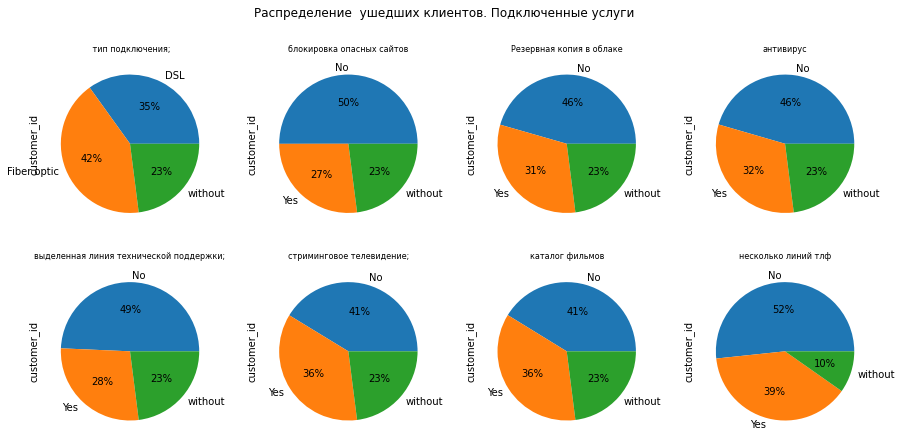

In [ ]:
# услуги
plt.figure(figsize=[15, 7])
plt.suptitle('Распределение  ушедших клиентов. Подключенные услуги')
plt.subplot(2,4,1)
segment_0.groupby(['internet_service'])['customer_id'].count().plot(kind = 'pie', autopct='%1.0f%%')
plt.title(' тип подключения;', fontsize= 8 )
plt.subplot(2,4,2)
segment_0.groupby(['online_security'])['customer_id'].count().plot(kind = 'pie', autopct='%1.0f%%')
plt.title('блокировка опасных сайтов', fontsize= 8 )
#plt.figure(figsize=[15, 20])
plt.subplot(2,4,3)
segment_0.groupby(['online_backup'])['customer_id'].count().plot(kind = 'pie', autopct='%1.0f%%')
plt.title('Резервная копия в облаке', fontsize= 8 )
#plt.figure(figsize=[15, 20])
plt.subplot(2,4,4)
segment_0.groupby(['device_protection'])['customer_id'].count().plot(kind = 'pie', autopct='%1.0f%%')
plt.title('антивирус', fontsize= 8 )
plt.subplot(2,4,5)
segment_0.groupby(['tech_support'])['customer_id'].count().plot(kind = 'pie', autopct='%1.0f%%')
plt.title('выделенная линия технической поддержки;', fontsize= 8 )
plt.subplot(2,4,6)
segment_0.groupby(['streaming_tv'])['customer_id'].count().plot(kind = 'pie', autopct='%1.0f%%')
plt.title('стриминговое телевидение;', fontsize= 8 )
#plt.figure(figsize=[15, 20])
plt.subplot(2,4,7)
segment_0.groupby(['streaming_movies'])['customer_id'].count().plot(kind = 'pie', autopct='%1.0f%%')
plt.title('каталог фильмов', fontsize= 8 )
#plt.figure(figsize=[15, 20])
plt.subplot(2,4,8)
segment_0.groupby(['multiple_lines'])['customer_id'].count().plot(kind = 'pie', autopct='%1.0f%%')
plt.title('несколько линий тлф', fontsize= 8 )
plt.show()

У большинства ушедших клиентов следующий набор услуг:
- тип подключения - оптоволокно,
- не подключена блокировка опасных сайтов,
- подключено облако с резервным копированием,
- подключен антивирус,
- линия техподдержки не выделена,
- подключено стриминговое тв,
- подключен каталог фильмов,
- подключение телефона к нескольким линиям одновременно.

## Подготовка данных

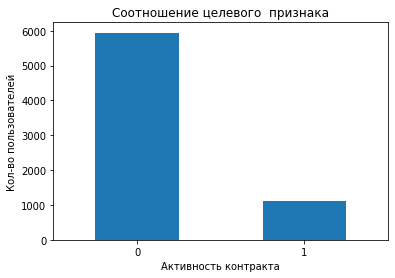

In [ ]:
#  проверим дисбаланс классов по целевому признаку
df['is_active'].value_counts().plot(kind='bar')
plt.title('Соотношение целевого  признака')
plt.ylabel('Кол-во пользователей')
plt.xticks(rotation = 0)
plt.xlabel('Активность контракта')
plt.show()

Раз в данных есть дисбаланс классов, нужно обязательно выполнить стратификацию по целевому признаку.

В этом случае тренировочные и тестовые выборки сохранят соотношение классов исходных данных, если при разбивке данных указать stratify=y.

In [ ]:
#разбиваем данные на признаки (х) и таргет (у)
X = df.drop('is_active', axis=1)
y = df['is_active']
# делим данные на тестовую и тренировочные выборки, 3:1
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = TEST_SIZE, random_state = RANDOM_STATE, stratify = y)
# проверим размеры получившихся выборок
train =X_train.shape[0]/X.shape[0]
test =y_test.shape[0]/y.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train))
print('Размер тестовой выборки - {:.0%}'.format(test))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


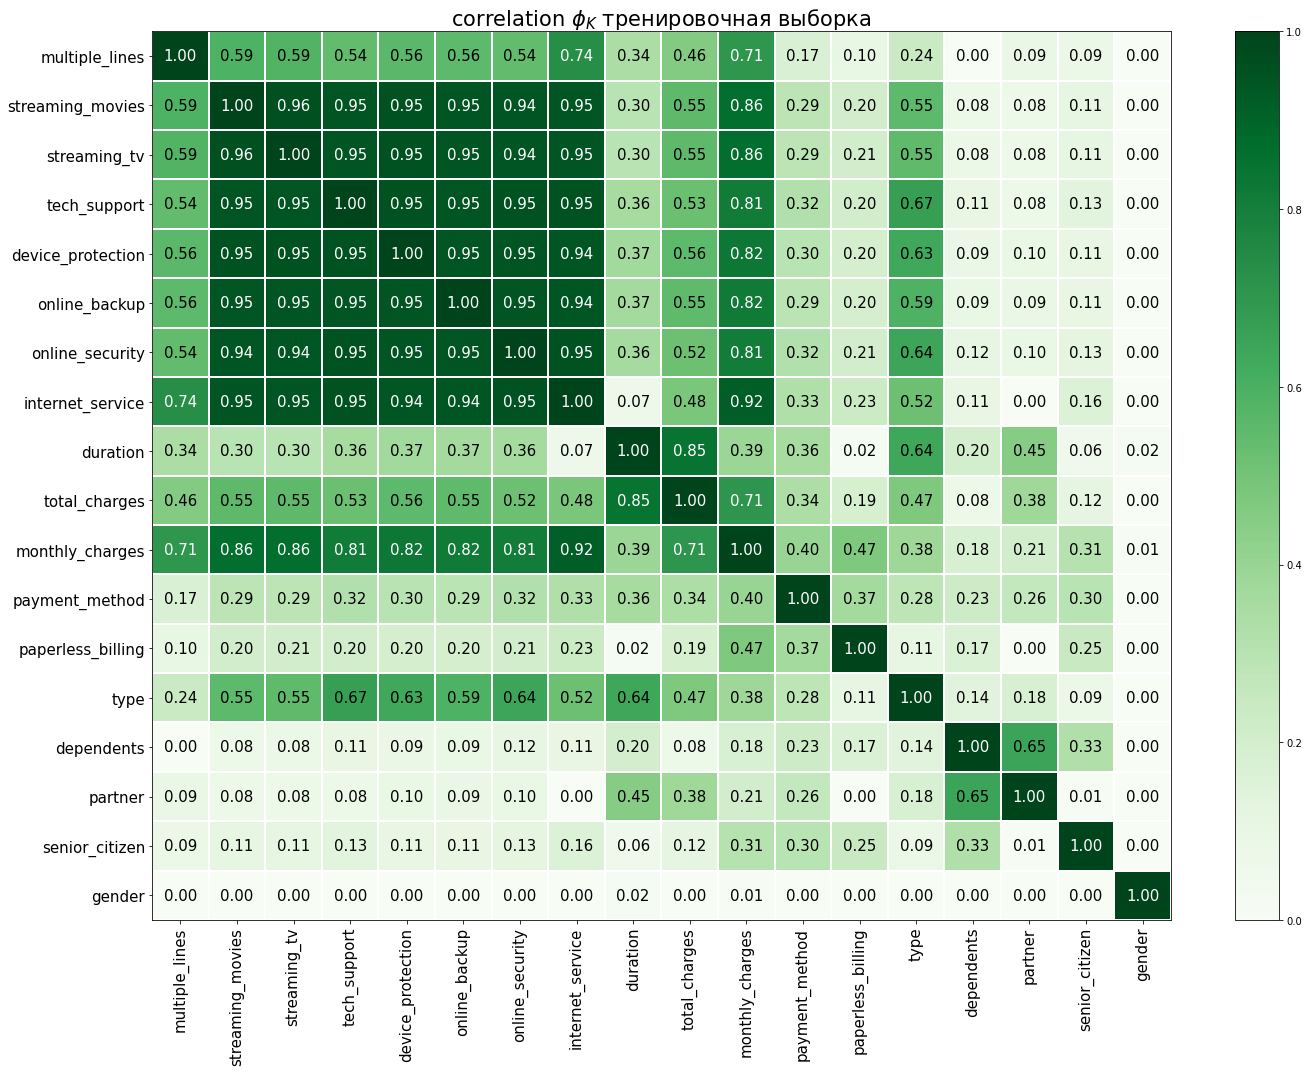

In [ ]:
# проверим мультиколинеарность с помощью phik на тренировочных данных
#отберем непрерывные столбцы для phik
interval_cols = ['total_charges', 'duration','monthly_charges']
# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(X_train.drop('customer_id', axis=1),interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$ тренировочная выборка',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Сильная связь обнаружена только между признаками - тип подключения и ежемесячная плата. Нужно избавиться от одного из признаков, не будем использовать признак ежемесячная плата

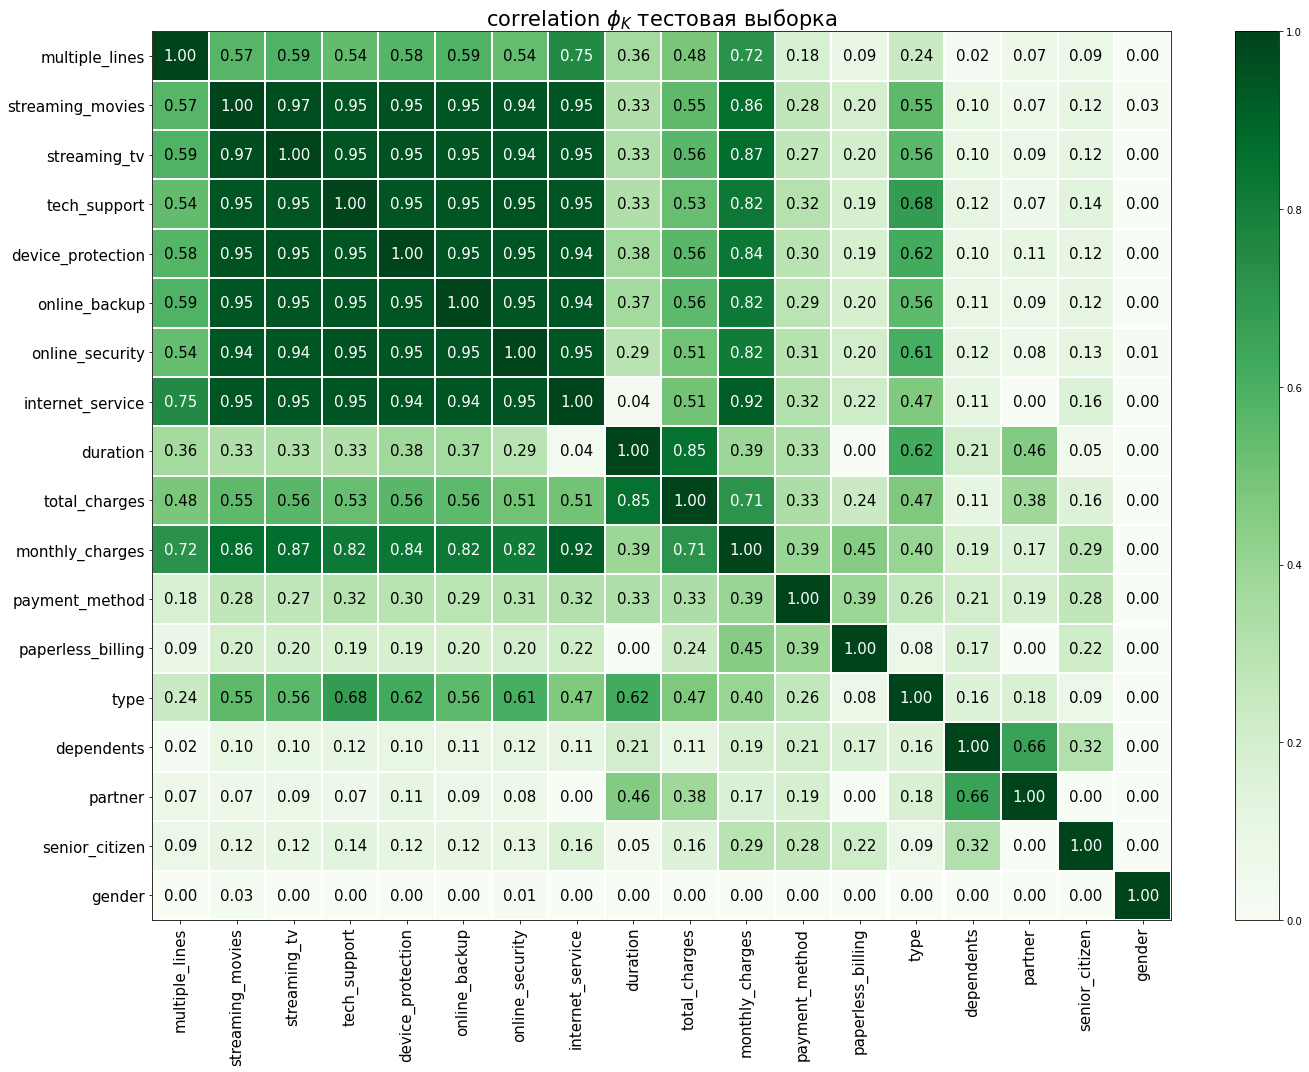

In [ ]:
# проверим мультиколинеарность с помощью phik на тестовых данных
#отберем непрерывные столбцы для phik
interval_cols = ['total_charges', 'duration','monthly_charges']
# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(X_test.drop('customer_id', axis=1),interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$ тестовая выборка',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

на тестовых данных также Сильная связь обнаружена только между признаками - тип подключения и ежемесячная плата.

Категориальные признаки я закодирую методом ordinal encoding
Количественные признаки нужно масштабировать с помощью StandardScaler.

In [ ]:
# создаём списки с названиями признаков
cat_cols = [
    'type', 'payment_method', 'internet_service', 'gender', 'online_security',
    'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
    'streaming_movies', 'paperless_billing', 'senior_citizen', 'partner', 'dependents', 'multiple_lines'
]
num_cols = ['total_charges', 'duration']

In [ ]:
scaler = StandardScaler()
ordinal = OrdinalEncoder( handle_unknown='use_encoded_value', unknown_value=np.nan)

In [ ]:
%%time
def pipeline_definition(model, model_name, param_grid,):
    transformer = ColumnTransformer([
        ('num', scaler, num_cols),
        ('cat',ordinal, cat_cols)
    ])

    pipe_final = make_pipeline(transformer, model)

    randomized = RandomizedSearchCV(
        pipe_final,
        param_grid,
        verbose=3,
        random_state=RANDOM_STATE,
        cv=5,
        n_jobs=-1,
        scoring='roc_auc'
    )
    start = time.time()
    randomized.fit(X_train, y_train)
    end = time.time()
    fit_time = round(end-start,4)
    best_score = randomized.best_score_
    best_model = randomized.best_estimator_[1]
    print('\n')
    print('Лучшая модель:')
    print(best_model)
    print('Метрика roc_auc на кросс-валидации:', round(best_score, 3))
    return best_model, best_score, fit_time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


##  Обучение моделей машинного обучения

Рассмотрю 3 модели

### DecisionTreeClassifier

In [ ]:
%%time
start = time.time()
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
dtc_params = {
    'decisiontreeclassifier__max_depth': range(2, 10, 2),
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__min_samples_split': range(2, 10)
}

best_dtc, dtc_score, dtc_time = pipeline_definition(dtc, 'DecisionTreeClassifier', dtc_params)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_samples_split=7; total time=   0.1s
[CV 2/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_samples_split=7; total time=   0.0s
[CV 3/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_samples_split=7; total time=   0.0s
[CV 4/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_samples_split=7; total time=   0.0s
[CV 5/5] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=2, decisiontreeclassifier__min_samples_split=7; total time=   0.0s
[CV 1/5] END decisiontreeclassifier__criterion=entropy, decisiontreeclassifier__max_depth=4, decisiontreeclassifier__min_samples_split=7; total time=   0.0s
[CV 2/5] END

### RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_params = {
     'randomforestclassifier__max_depth': range(4, 16, 4),
     'randomforestclassifier__n_estimators': range(200, 400, 50),
     'randomforestclassifier__min_samples_leaf': range(1,5),
     'randomforestclassifier__criterion': ['gini', 'entropy']
}

best_rf, rf_score, rf_time = pipeline_definition(rf, 'RandomForestClassifier', rf_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=350; total time=   0.9s
[CV 2/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=350; total time=   0.9s
[CV 3/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=350; total time=   0.9s
[CV 4/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=350; total time=   0.9s
[CV 5/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n

### LGBMClassifier

In [ ]:
lgbm = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_params = {

    'lgbmclassifier__max_depth': range(2, 10, 2),
    'lgbmclassifier__learning_rate': [0.01, 0.1, 1, 10]
}

best_lgbm, best_lgbm_score, lgbm_time = pipeline_definition(lgbm, 'LGBMClassifier', lgbm_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=2; total time=   0.3s
[CV 2/5] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=2; total time=   0.3s
[CV 3/5] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=2; total time=   0.4s
[CV 4/5] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=2; total time=   0.4s
[CV 5/5] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=2; total time=   0.5s
[CV 1/5] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=8; total time=   1.2s
[CV 2/5] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=8; total time=   1.1s
[CV 3/5] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=8; total time=   1.2s
[CV 4/5] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=8; total time=   2.4s
[CV 5/5] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=8

## Выбор лучшей модели

построим датафрейм по моделям, будем смотреть метрику на кроссвалидации и время обучения

In [ ]:
models = [  "DecisionTree", "RandomForest", "LGBM"]
df = [ [dtc_score, dtc_time],
        [rf_score, rf_time],
        [best_lgbm_score, lgbm_time]]

pd.DataFrame(data=df, index=models, columns=["score", "fit_time"])

,score,fit_time
DecisionTree,0.797625,2.0686
RandomForest,0.830930,51.3542
LGBM,0.866557,78.7162


быстрее, но хуже всего отработало дерево решений, самым оптимальным вариантом является LGBM. Хорошая метрика и среднее время. Думаю, можем использовать LGBM с ее лучшими параметрами.

In [ ]:

transformer = ColumnTransformer([('num', scaler, num_cols),
                              ('cat', ordinal, cat_cols)])
pipe = make_pipeline(transformer, best_lgbm)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('ROC-AUC на тестовой выборке:', round(roc_auc_score(y_test, y_pred), 3))
print('Accuracy:', round(accuracy_score(y_test, y_pred), 3))


ROC-AUC на тестовой выборке: 0.705
Accuracy: 0.893


Accuracy показывает, скольким объектам модель смогла правильно присвоить класс,то есть Accuracy — эта метрика показывает долю верных ответов модели.

model = best_lgbm
#влияние признаков для модели LGBMRegressor
lgb.plot_importance(model, height=.5);

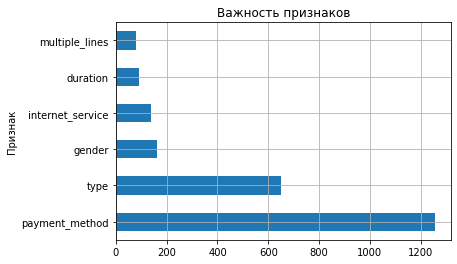

In [ ]:
model = best_lgbm
x = X[['type', 'payment_method', 'internet_service', 'gender', 'online_security',
    'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
    'streaming_movies', 'paperless_billing', 'senior_citizen', 'partner', 'dependents', 'multiple_lines','total_charges', 'duration']]
(pd.Series(model.feature_importances_, index=x.columns)
   .nlargest(6)
   .plot(kind='barh',ylabel='Признак',grid=True))
plt.title ('Важность признаков');

Топ 3 признака: пол, тип подключения, метод оплаты.

## Общий вывод и рекомендации заказчику

В рамках проекта была проделана большая работа по изучению данных, связанных с телекоммуникационными услугами. Я применила все знания и умения, полученные в ходе обучения и использовала  информацию из дополнительных источников.

Для начала я открыла файлы с данными и ознакомилась с ними: узнала сколько строк и столбцов, какие типы данных есть, посмотрела на описательную статистику по данным(describe).

   На следующем шаге шла подготовка данных к анализу:  пришлось переименовывать столбцы  и перевести их в змеиный регистр, я обработала пропуски , заменила типы данных, дублей не было.

В рамках исследовательского анализа Я проверила призгаки, построила графики по этим данным.

далее мы объединили данные в один датасет из 4-х и снова проверили его на пропуски, дубли. Был получен портрет клиента, который расторгает контракт

Я Разделила выборку на тренировочную и  тестовую в соотношении 3 к 1.
С помощью phik была построена матрица кореляции, мультиколинеарность была обнаружена.

Категориальные признаки для  моделей я закодировала методом ordinal encoding.

Для решения задачи писпользовались следующие модели: DecisionTreeClassifier с глубиной дерева 6 и минимальным количеством выборок=8, RandomForestClassifier "LGBMClassifier".

Метрики у моделей с подобранными параметрами получились на валидационных выборках следующие:

- 0.8 у дерева решений
- 0.83 у случайного леса
- 0.87 у LGBM.

По критериям метрика-время была выбрана лучшей модель LGBMClassifier.

На тестовой выборке данная метрика составила 0.705.

По результатам портрета "проблемных" клиентов, возможно стоит уделить внимание и придумать промо предложение для женатх/замужних клиентов не достигших пенсионного возраста и не имеющих детей.

У большинства ушедших клиентов следующий набор услуг:
- тип подключения - оптоволокно,
- не подключена блокировка опасных сайтов,
- подключено облако с резервным копированием,
- подключен антивирус,
- линия техподдержки не выделена,
- подключено стриминговое тв,
- подключен каталог фильмов,
- подключение телефона к нескольким линиям одновременно.

Поэтому также можно создать тариф с выгодной ценой, включающий комплекс из самых востребованными услугами.
